In [1]:
from pathlib import Path
import json
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
results = pd.read_csv("exp_results.csv")
results

,img_method,text_method,classif_method,f1_score
0,resnet50_features,bag_of_words,LogisticRegression,0.67489
1,resnet50_features,tf_idf,LogisticRegression,0.63171
2,resnet50_features,spacy_approach,LogisticRegression,0.63050
3,resnet50_features,word2vec_approach,LogisticRegression,0.57640
4,resnet50_features,bag_of_words,CatBoostClassifier,0.57421
5,resnet50_features,tf_idf,CatBoostClassifier,0.57266
6,resnet50_features,spacy_approach,CatBoostClassifier,0.59685
7,resnet50_features,word2vec_approach,CatBoostClassifier,0.57206


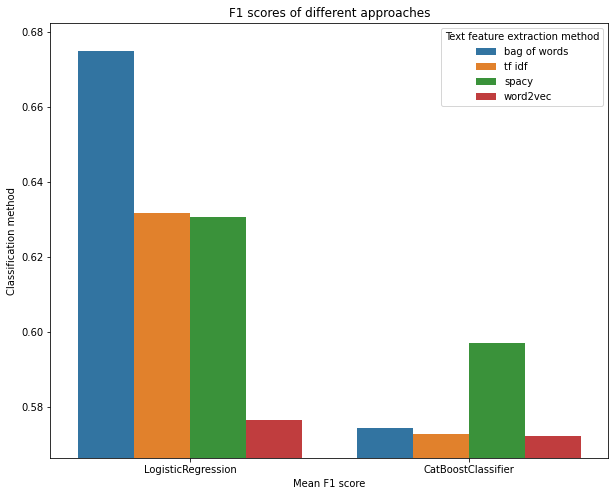

In [5]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data=results.rename(columns={"text_method": "Text feature extraction method"})
        .replace({key: key.replace("_approach", "").replace("_", " ") for key in results.text_method.unique()}),
     x="classif_method", y="f1_score", hue="Text feature extraction method", ax=ax)
ax.set_ylim(results.f1_score.min() * 0.99, results.f1_score.max() * 1.011)
ax.set_xlabel("Mean F1 score")
ax.set_ylabel("Classification method")
ax.set_title("F1 scores of different approaches")
plt.show()

In [86]:
data_dir = Path("data")
embeds_dir = Path("embeddings")

movie_info = pd.read_csv(data_dir / "movie_info.csv")
print(movie_info[["title", "plot", "genres"]].isna().sum())
movie_info["genres"] = movie_info["genres"].map(lambda x: json.loads(x.replace("\'", "\"")))

classes = ["Action", "Adventure", "Animation", "Biography", "Comedy", "Crime", "Documentary", "Drama",
            "Family", "Fantasy", "Film-Noir", "History", "Horror", "Music", "Musical", "Mystery",
            "Romance", "Sci-Fi", "Short", "Sport", "Superhero", "Thriller", "War", "Western"]

for genre in classes:
    movie_info[genre] = movie_info["genres"].map(lambda x: genre in x).astype(int)
len(movie_info)

title        0
plot      1405
genres       0
dtype: int64


4702

In [83]:
movie_info[["title", "plot", "genres"]].isna().sum()

title     0
plot      0
genres    0
dtype: int64

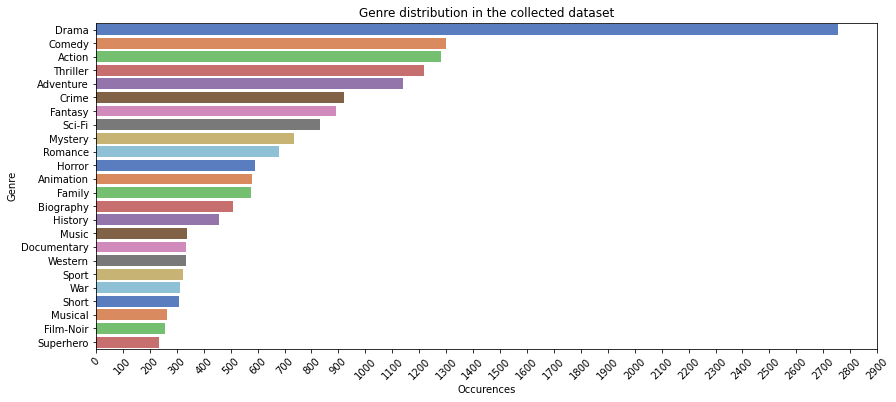

In [101]:
fig, ax = plt.subplots(figsize=(14, 6))
# movie_info[classes].sum().sort_values().plot.bar(ax=ax)
data_to_plot = movie_info[classes].sum().sort_values(ascending=False)
sns.barplot(x=data_to_plot.values, y=data_to_plot.index, palette="muted")
plt.xticks(rotation=45)
plt.xticks(range(0, 3000, 100))
plt.xlabel("Occurences")
plt.ylabel("Genre")
plt.title("Genre distribution in the collected dataset")
plt.show()

# Feature importance

In [7]:
tm_title_embeds = np.load(embeds_dir / f"spacy_approach_title.npy")
tm_plot_embeds = np.load(embeds_dir / f"spacy_approach_plot.npy")
image_embeds = np.load(embeds_dir / f"resnet50_features.npy")

In [8]:
X = np.column_stack([image_embeds, tm_title_embeds, tm_plot_embeds])
y = movie_info[classes].values

In [9]:
from catboost import CatBoostRegressor

c:\Users\Владислав\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [ ]:
models = [CatBoostRegressor(random_state=0, silent=True, iterations=100) for _ in range(len(classes))]
for i in tqdm(range(len(models))):
    models[i].fit(X, y[:, i])

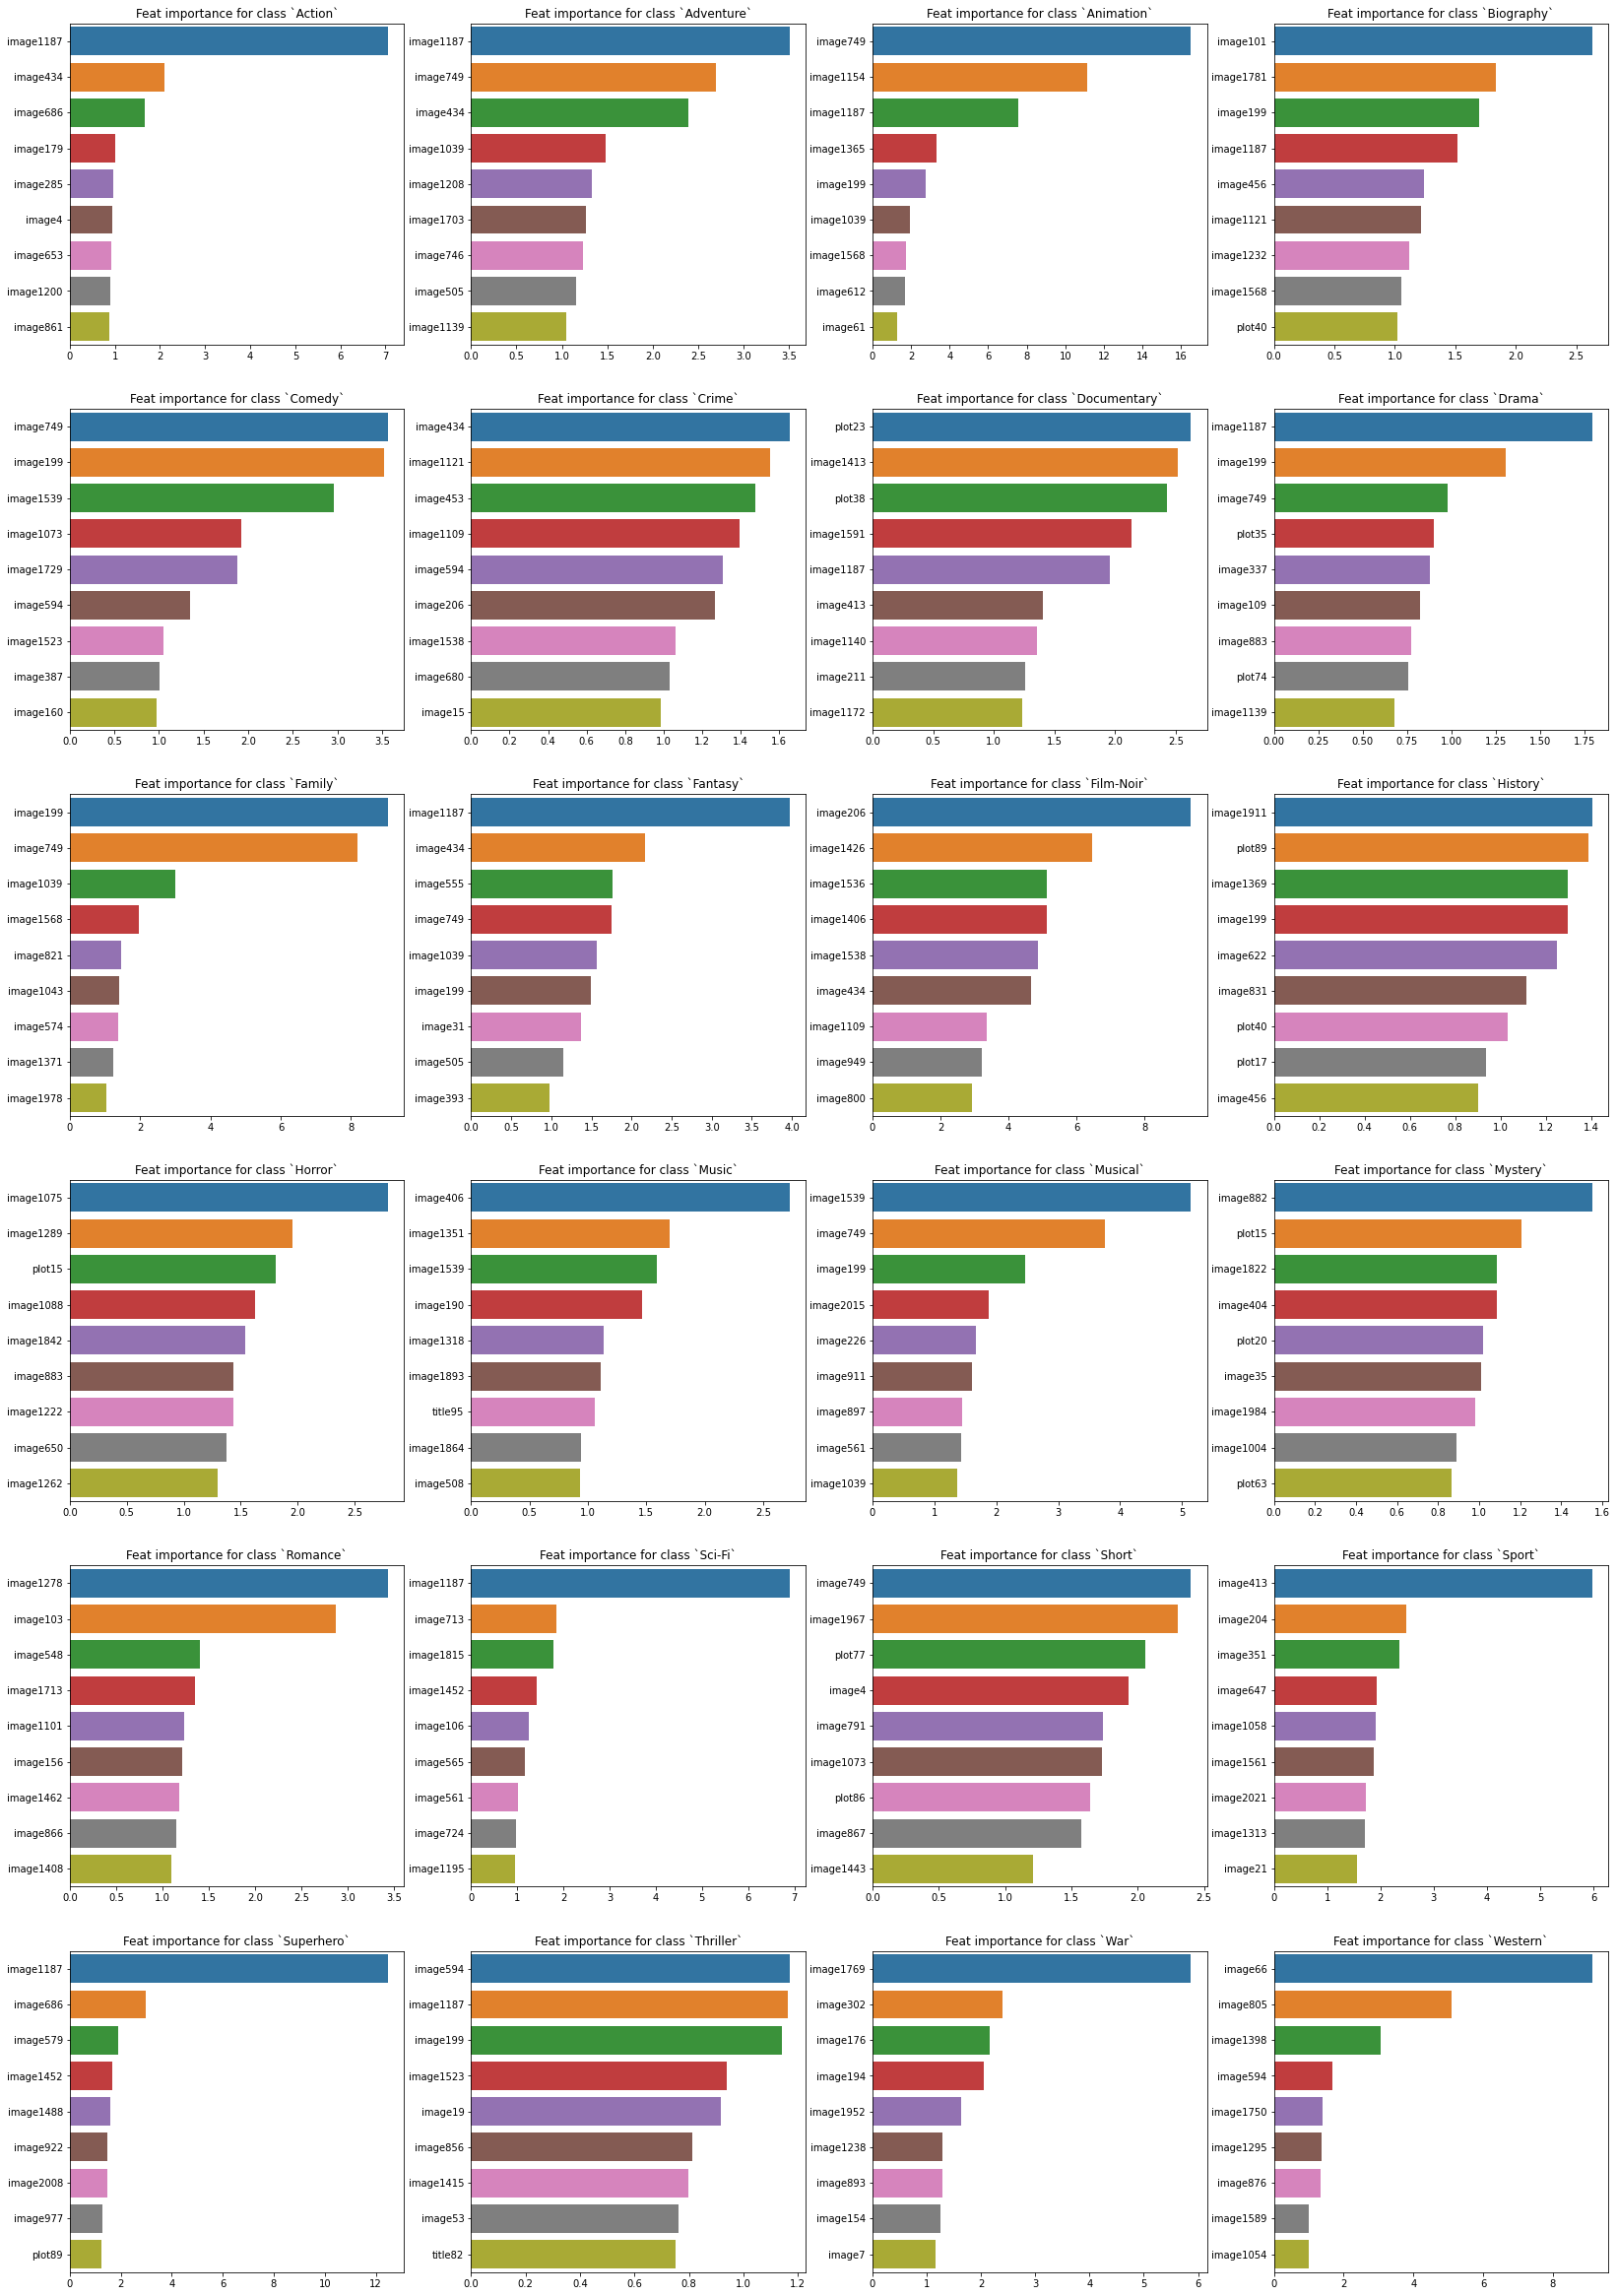

In [ ]:
feature_names = [f"image{i}" for i in range(image_embeds.shape[1])] + [f"title{i}" for i in range(tm_title_embeds.shape[1])] + \
    [f"plot{i}" for i in range(tm_plot_embeds.shape[1])]

fig, axs = plt.subplots(6, 4, figsize=(28, 42))
for i in range(6):
    for j in range(4):
        k = i * 4 + j
        inds = models[k].feature_importances_.argsort()[: - 10: - 1]
        sns.barplot(x=models[k].feature_importances_[inds], y=[feature_names[ind] for ind in inds], ax=axs[i][j])
        axs[i][j].set_title(f"Feat importance for class `{classes[k]}`")

# Best method classification examples

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [11]:
data_dir = Path("data")
imgs_dir = data_dir / "imgs"
embeds_dir = Path("embeddings")

movie_info = pd.read_csv(data_dir / "movie_info.csv")
movie_info["plot"].fillna("No description", inplace=True)
movie_info["genres"] = movie_info["genres"].map(lambda x: json.loads(x.replace("\'", "\"")))

classes = ["Action", "Adventure", "Animation", "Biography", "Comedy", "Crime", "Documentary", "Drama",
            "Family", "Fantasy", "Film-Noir", "History", "Horror", "Music", "Musical", "Mystery",
            "Romance", "Sci-Fi", "Short", "Sport", "Superhero", "Thriller", "War", "Western"]

for genre in classes:
    movie_info[genre] = movie_info["genres"].map(lambda x: genre in x).astype(int)

image_embeds = np.load(embeds_dir / "resnet50_features.npy")
title_embeds = np.load(embeds_dir / "bag_of_words_title.npy")
plot_embeds = np.load(embeds_dir / "bag_of_words_plot.npy")

val_size = 0.2

X = np.column_stack([image_embeds, title_embeds, plot_embeds])
X_train, X_val = train_test_split(X, test_size=val_size, random_state=0)
y = movie_info[classes].values
y_train, y_val = train_test_split(y, test_size=val_size, random_state=0)

models = [LogisticRegression(random_state=0, solver="saga") for _ in range(len(classes))]

for i in tqdm(range(len(models))):
    models[i].fit(X_train, y_train[:, i])

  0%|          | 0/24 [00:00<?, ?it/s]c:\Users\Владислав\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  4%|▍         | 1/24 [01:31<35:11, 91.80s/it]c:\Users\Владислав\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  8%|▊         | 2/24 [03:02<33:26, 91.20s/it]c:\Users\Владислав\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 12%|█▎        | 3/24 [04:36<32:22, 92.49s/it]c:\Users\Владислав\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

In [82]:
import pickle

models_dir = Path("models")
for i in range(len(models)):
    with open(models_dir / f"{i}.npy", "wb") as f:
        pickle.dump(models[i], f)

In [65]:
train_inds, test_inds = train_test_split(range(len(movie_info)), test_size=val_size, random_state=0)

ind = 202
preds = np.round(np.array([models[i].predict_proba(X_val[ind: ind + 1])[0, 1] for i in range(len(classes))]), 2)
print(movie_info.iloc[test_inds[ind]][["imdb_id", "title", "plot"]].values)
pd.DataFrame(list(zip(classes, preds, y_val[ind])), columns=["genres", "predicted probability", "ground truth"])

[7097896 'Venom: Let There Be Carnage'
 'Eddie Brock struggles to adjust to his new life as the host of the alien symbiote Venom, which grants him super-human abilities in order to be a lethal vigilante. Brock attempts to reignite his career by interviewing serial killer Cletus Kasady, who becomes the host of the symbiote Carnage and escapes prison after a failed execution.']


,genres,predicted probability,ground truth
0,Action,0.96,1
1,Adventure,0.96,1
2,Animation,0.00,0
3,Biography,0.00,0
4,Comedy,0.02,0
5,Crime,0.04,0
6,Documentary,0.00,0
7,Drama,0.08,0
8,Family,0.01,0
9,Fantasy,0.03,0


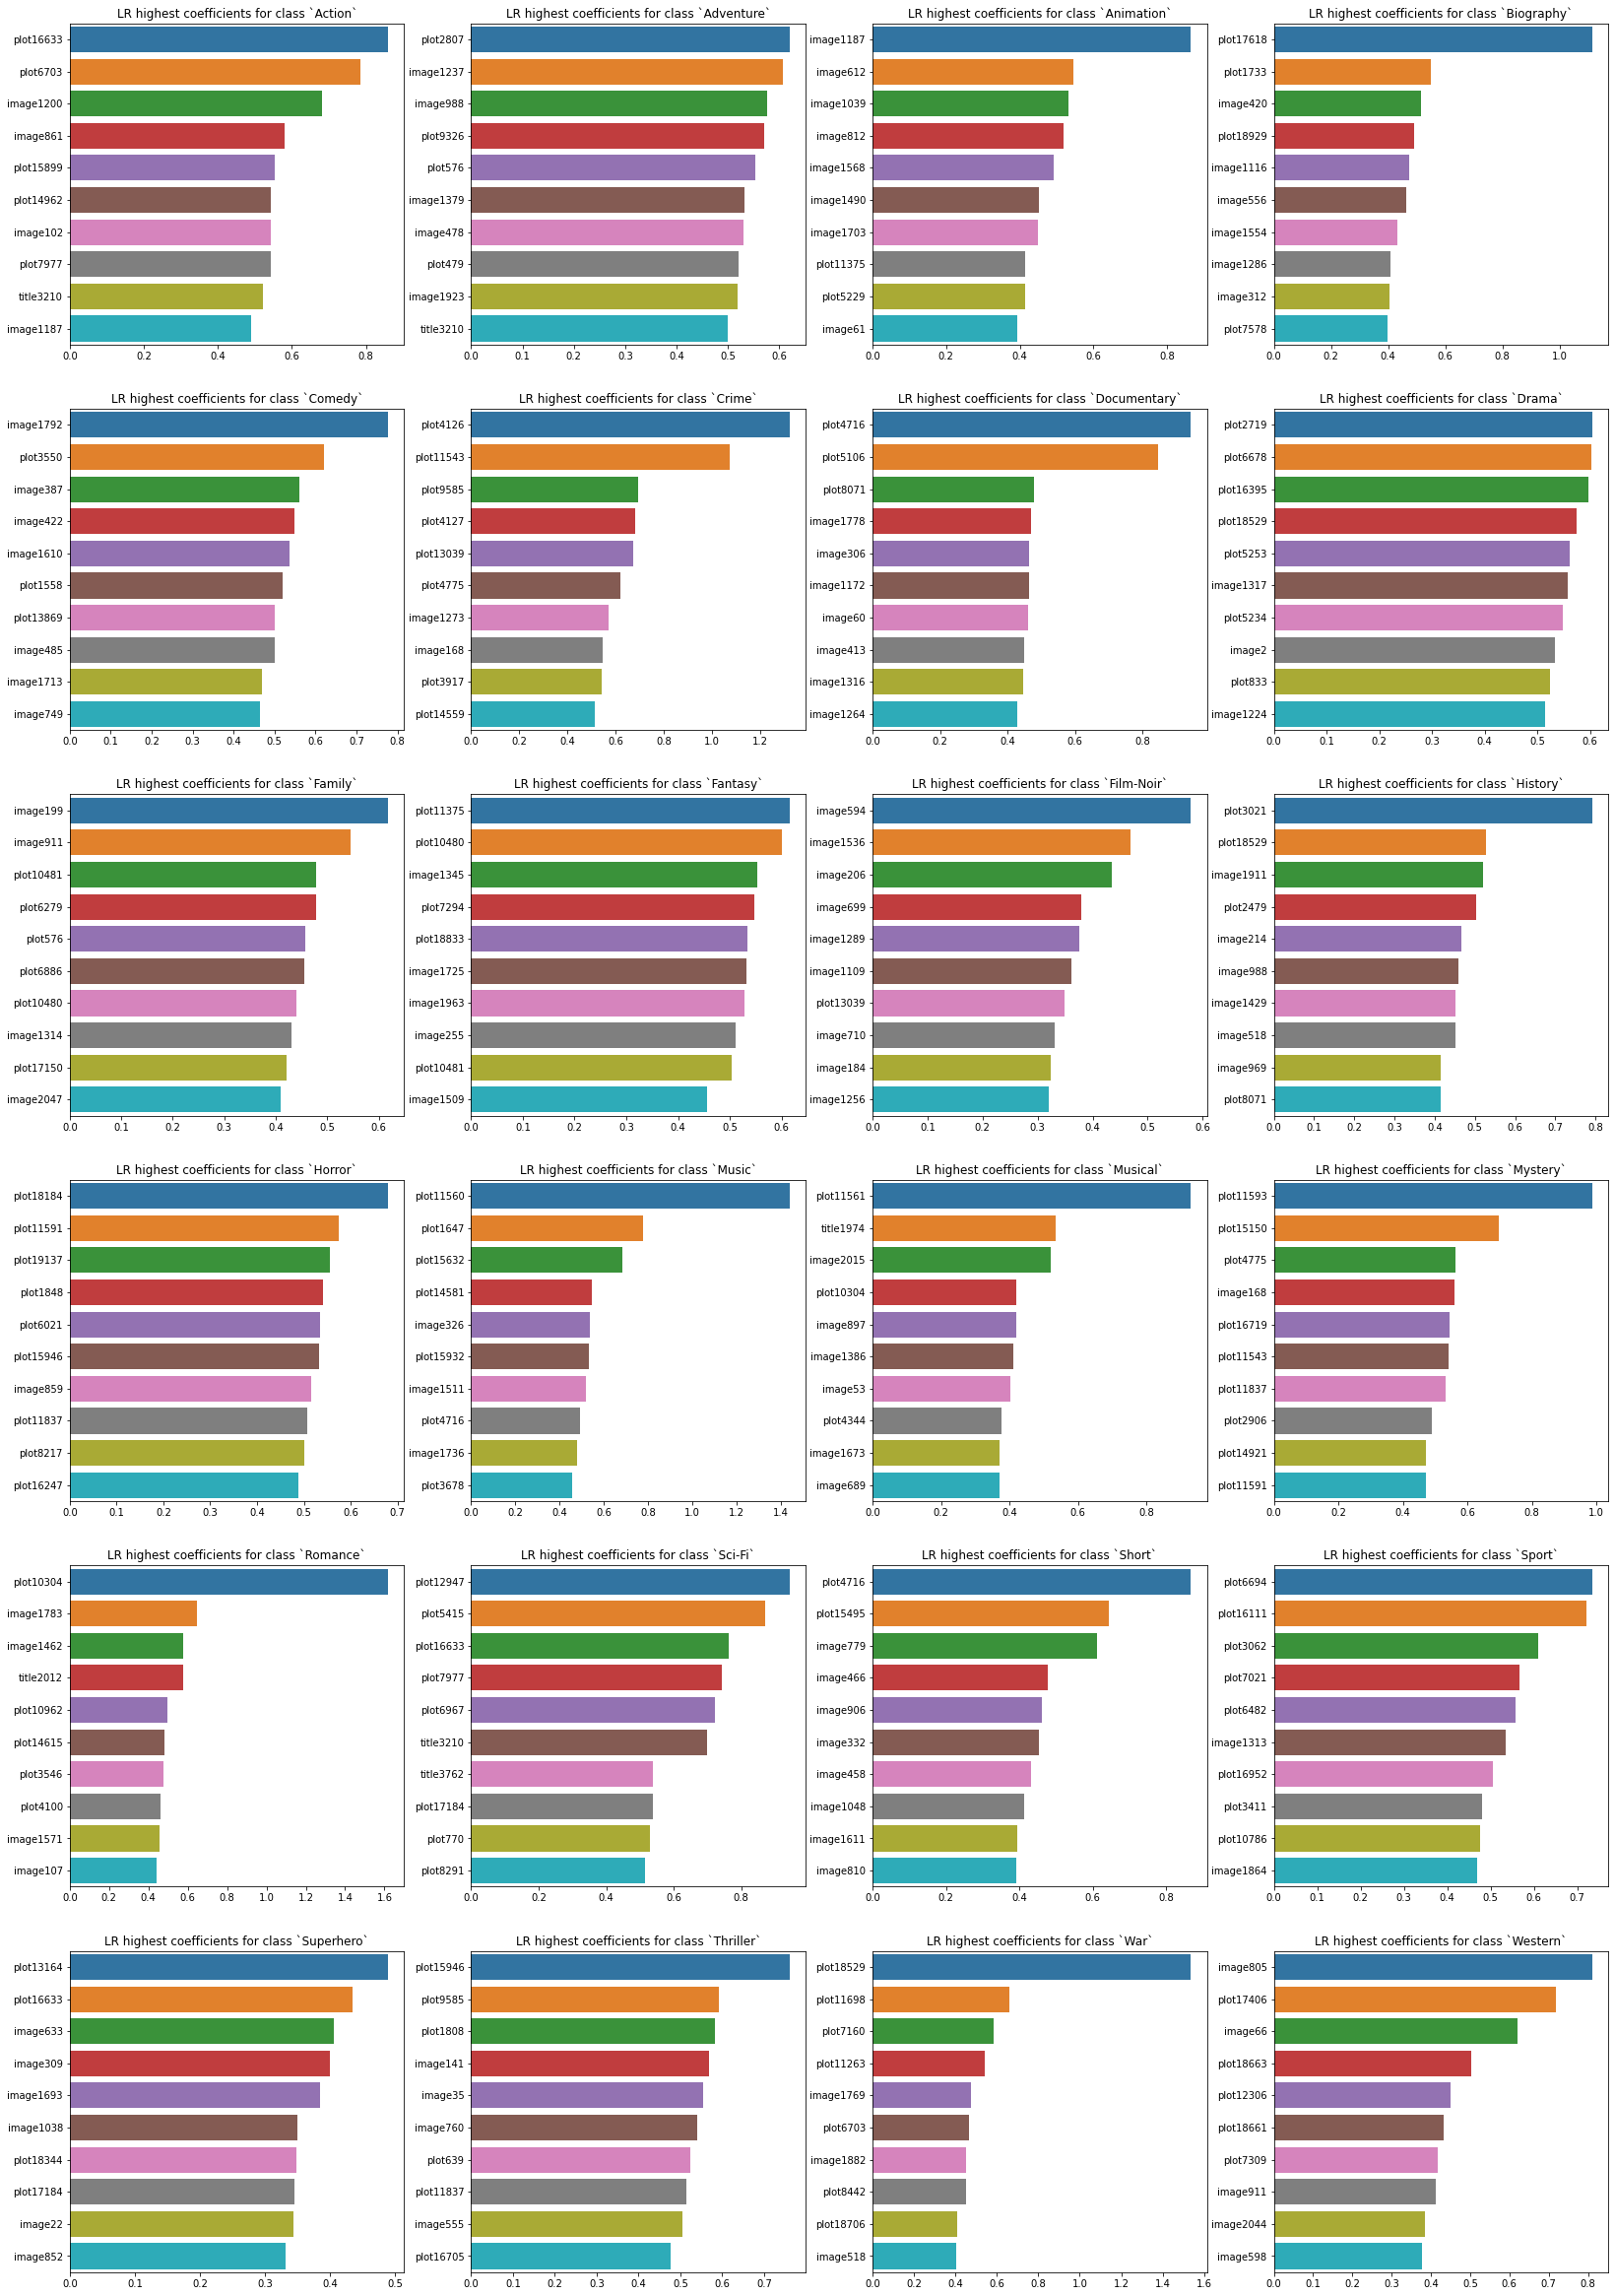

In [81]:
fig, axs = plt.subplots(6, 4, figsize=(28, 42))
for i in range(6):
    for j in range(4):
        class_ind = i * 4 + j
        inds = np.argsort(models[class_ind].coef_.flatten())[:: - 1][:10]
        best_coefs = models[class_ind].coef_[0, inds]
        best_feats = np.array([f"image{i}" for i in range(image_embeds.shape[1])] + [f"title{i}" for i in range(title_embeds.shape[1])] + 
            [f"plot{i}" for i in range(plot_embeds.shape[1])])\
            [inds].flatten()
        sns.barplot(x=best_coefs, y=best_feats, ax=axs[i][j])
        axs[i][j].set_title(f"LR highest coefficients for class `{classes[class_ind]}`")